### QED-C Application-Oriented Benchmarks - Analyze Observable Methods

The notebook implements a procedure for analyzing different methods for computing observables.
Given a specific problem size (number of qubits), a Hamiltonian, an aboservable method (group_method), and a given total shot count, generate a specified number of random input states, and measure the resulting expectation value, both exactly and computed using the quantum expactation algorithm.

Results are plotted and the difference between the exact expectation value at each random input and the computed value is highlighted.

DEVNOTE: Much of the code in this notebook will be re-factored into other modules, as this work evolves.


### Program Configuration

In [ ]:
# Select the API to use and load the benchmark program
api = "qiskit"
from hamlib import hamlib_simulation_benchmark

# configure the QED-C Benchmark package for use with the given API
_, _ = hamlib_simulation_benchmark.qedc_benchmarks_init(api)

# Select the benchmark parameters
num_qubits = min_qubits = max_qubits = 12
skip_qubits = 1
max_circuits = 1
num_shots = 4000

# Set number of Trotter steps K and total time t
K = 0
t = 0.001

# Number of iterations performed with random initialization
iterations = 2

use_diag_method = True
group_method = "N"
distribute_shots = False

# use an ansatz to generate random states; default is to use integer initialization
use_ansatz_initial_state = True

# method to use for weighted shot distribution: max_sq, mean_sq, or max
wsd_method = "max"

# Select the backend 
#backend_id = "qasm_simulator"
backend_id = "statevector_simulator"
provider_backend = None
exec_options = {}

#############

# place resulting data and images into a folder with "paper" suffix
from _common import metrics
metrics.data_suffix = "_analysis"
hamlib_simulation_benchmark.data_suffix = "_analysis"

hamlib_simulation_benchmark.max_qubits_exact = 16

skip_execution = False


In [ ]:
import numpy as np
import time
import os

np.random.seed(42)

from _common.qiskit import execute

# Import HamLib helper functions (from _common)
from hamlib._common import hamlib_utils

# Import Hamlib Simulation kernel (from qiskit)
from hamlib.qiskit import hamlib_simulation_kernel

# Import Observable helper functions
from hamlib._common import observables
from hamlib._common import evolution_exact

#########  Configure a QASM simulator, possibly noisy
backend_id = "qasm_simulator"
exec_options = {}

# Custom optimization options can be specified in this cell (below is an example)

# # Define a custom noise model to be used during execution
import _common.custom.custom_qiskit_noise_model as custom_qiskit_noise_model

# noisy, QV = 32 ...
#exec_options.update({ "noise_model": custom_qiskit_noise_model.my_noise_model() })

#ideal ...
#exec_options.update({ "noise_model": None })

# set up the execution target
execute.set_execution_target(backend_id, exec_options=exec_options)

# object used to store metrics
from hamlib._common.new_functions import metrics_object



### List of Available Hamiltonians and Sizes
For the example illustrated below, select one of the available Hamiltonian (name, params, size) tuples.


In [3]:
# List of HamLib filename and parameter tuples, with max_qubits limit array
# Note that the 4th entry in the array is used in the cell below which executes a noisy simulation

# DEVNOTE: this notebook does not currently use the last field of the items in this array

hamiltonians = [
    ('condensedmatter/tfim/tfim', { "1D-grid": "pbc", "h": 2 }, [24,28,28,28, 16] ),
    ('condensedmatter/heisenberg/heis', { "1D-grid": "pbc", "h": 2 }, [24,28,28,28, 16] ),
    ('condensedmatter/fermihubbard/FH_D-1', { "1D-grid": "pbc", "enc": "bk", "U":12 }, [20,24,24,24, 14] ),
    ('condensedmatter/bosehubbard/BH_D-1_d-4', { "1D-grid": "nonpbc", "enc": "gray", "U":10 }, [16,24,24,24, 12] ),
    ('chemistry/electronic/standard/H2', { "ham_BK": "" }, [8,12,12,12, 8] ),
    ('chemistry/electronic/standard/B2', { "ham_BK": "" }, [8,12,12,12, 8] ),
    ('chemistry/electronic/standard/NH', { "ham_BK": "" }, [8,12,12,12, 8] ),
    ('chemistry/electronic/standard/CH', { "ham_BK": "" }, [8,12,12,12, 8] ),
    ]

group_method_list = [ "simple", "N", "estimator" ]

---
## Custom Functions used in this Notebook

### Ansatz Definition - Suitable Quantum Circuit for Initial State
Select the type of ansatz circuit to use

DEVNOTE: this analysis does not currently use the ansatz, but it will later.


In [ ]:
import numpy as np
from qiskit.circuit.library import EfficientSU2
from qiskit import QuantumCircuit
from hamlib._common.result_generation_functions import get_ansatz

### Generate Random Initialization States
Here we generate initialization states using a bitstring containing 0s and 1s only.

In [ ]:
import random
from hamlib._common.result_generation_functions import generate_random_int_and_bitstring

### Custom Observable Estimation Function
This function wraps the four steps of the process into a single function.

In [ ]:
from hamlib._common.new_functions import create_measurement_circuts, do_execute, compute_energy
from hamlib._common.new_functions import compute_exact_value
from hamlib._common.result_generation_functions import estimate_expectation_value_top

### Generate N Random Input States and Collect Data about Computation of Observable (Energy)


---
## Observable Estimation Loop for Analysis
Here we compute an observable (energy) for the given Hamiltonian, sweeping over the specified set of group methods.  Using the value and timing analysis plots, this provides a means to compare the behavior of these methods.

In [ ]:
from qiskit_aer import Aer
from hamlib._common.result_generation_functions import prepare_random_initial_state, do_random_state_loop

## TFIM

In [8]:

# Note: we will loop over multiples here later
hamiltonian_name, hamiltonian_params, _ = hamiltonians[0]     # just do a single Hamiltonian in this notebook


print(f"\n*******************************************************************************************")

print(f"\nAnalyze Observable Computation Methods for {hamiltonian_name} {hamiltonian_params}\n")

# load the HamLib file for the given hamiltonian name
hamlib_utils.load_hamlib_file(filename=hamiltonian_name)

# return a sparse Pauli list of terms queried from the open HamLib file
sparse_pauli_terms, dataset_name = hamlib_utils.get_hamlib_sparsepaulilist(num_qubits=num_qubits, params=hamiltonian_params)

if not sparse_pauli_terms:
    print(f"\n******** Cannot proceed since no dataset was found for {num_qubits} qubits.\n", flush=True)
    sys.exit()
    
print("")
print(f"... dataset_name = {dataset_name}")
print(f"... number of terms in Hamiltonian = {len(sparse_pauli_terms)}")
#print(f"... sparse_pauli_terms = \n{sparse_pauli_terms}")
print("")



*******************************************************************************************

Analyze Observable Computation Methods for condensedmatter/tfim/tfim {'1D-grid': 'pbc', 'h': 2}


... dataset_name = graph-1D-grid-pbc-qubitnodes_Lx-12_h-2
... number of terms in Hamiltonian = 24



done
----1 group -----

... Number of terms in Hamiltonian: 24
... Number of groups created: 2

... Pauli Term Groups:

Perform Observable Computation for: condensedmatter/tfim/tfim {'1D-grid': 'pbc', 'h': 2}
... executing on num_qubits = 12, shots = 4000
    grouping method = N, use_diag_method = True, num_k = 1
    number of terms in Hamiltonian = 24, number of groups created = 2

..
⚠️ Warning: Significant negative bias detected in the error distribution!
error: 0.19483232477590706
mean: -0.09354412153117064
----6 group -----

... Number of terms in Hamiltonian: 24
... Number of groups created: 2

... Pauli Term Groups:

Perform Observable Computation for: condensedmatter/tfim/tfim {'1D-grid': 'pbc', 'h': 2}
... executing on num_qubits = 12, shots = 4000
    grouping method = N, use_diag_method = True, num_k = 6
    number of terms in Hamiltonian = 24, number of groups created = 2

..
⚠️ Warning: Significant negative bias detected in the error distribution!
error: 0.0568323247759070

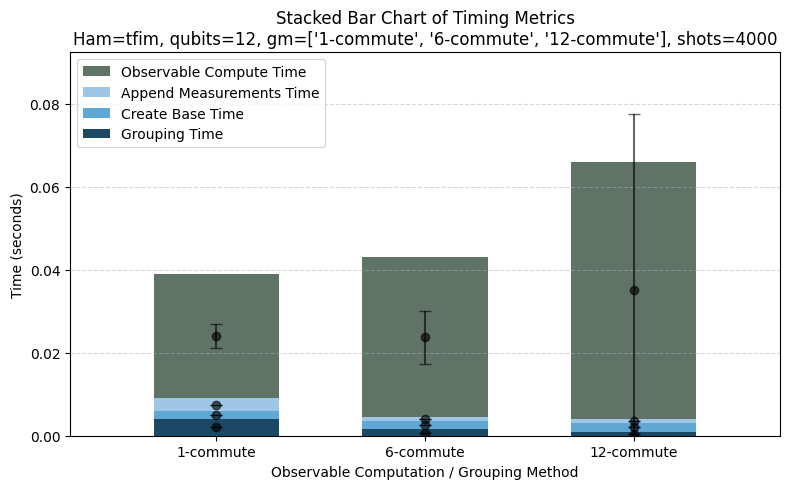

In [ ]:
# Arrange the Pauli terms into commuting groups based on group_method, for use in cells below

from hamlib._common.metric_plots import get_errors
from hamlib._common.new_functions import compute_timing_stats
from hamlib._common.metric_plots import plot_timing_analysis_bar_chart

ks = [1, int(1/2 * num_qubits), num_qubits]
group_method_labels = [f'{num_k}-commute' for num_k in ks]

timing_datasets = []
timing_dataset_labels = []
print("done")


initial_states = []
initial_circuits = []
for it in range(iterations):
    init_state, init_qc = prepare_random_initial_state(num_qubits)
    initial_states.append(init_state)
    initial_circuits.append(init_qc)
    

for num_k, group_method_label in zip(ks, group_method_labels):
    print(f'----{num_k} group -----')

    pauli_term_groups, pauli_str_list = hamlib_simulation_benchmark.find_pauli_groups(num_qubits, sparse_pauli_terms, group_method, num_k)
    
    print("")
    print(f"... Number of terms in Hamiltonian: {len(sparse_pauli_terms)}")
    print(f"... Number of groups created: {len(pauli_term_groups)}")
    print("")
    
    print(f"... Pauli Term Groups:")
    
    print("\n======================================================================================")
    print(f"Perform Observable Computation for: {hamiltonian_name} {hamiltonian_params}")
    print(f"... executing on num_qubits = {num_qubits}, shots = {num_shots}")
    print(f"    grouping method = {group_method}, use_diag_method = {use_diag_method}, num_k = {num_k}")
    pauli_term_groups, _ = hamlib_simulation_benchmark.find_pauli_groups(num_qubits, sparse_pauli_terms, group_method, num_k)
    print(f"    number of terms in Hamiltonian = {len(sparse_pauli_terms)}, number of groups created = {len(pauli_term_groups)}")
    
    init_values, exact_energies, computed_energies, metrics_array = do_random_state_loop(num_qubits, sparse_pauli_terms, group_method, num_shots, K, t,
                                                                                         num_k, use_diag_method, iterations, initial_states, initial_circuits, distribute_shots,
                                                                                         backend_id, wsd_method)

    # Generate the value anlysis plots
    std_error, mean = get_errors(
                hamiltonian_name,
                backend_id,
                num_qubits,
                group_method_label,
                num_shots,
                exact_energies,
                computed_energies
            )
    print('error:', std_error)
    print('mean:', mean)


    # Compute statistics for the collected metrics
    stats_result = compute_timing_stats(metrics_array)
    #print(stats_result)
    
    timing_datasets.append(stats_result)
    timing_dataset_labels.append( { "name": "Dataset", "label": f"{group_method_label}" })
    
#categories = ["grouping_time", "create_base_time", "append_measurements_time", "execute_circuits_time", "observable_compute_time"]
categories = ["grouping_time", "create_base_time", "append_measurements_time", "observable_compute_time"]

# Version 1: Markers in the middle of the bars
plot_timing_analysis_bar_chart(
        hamiltonian_name,
        backend_id,
        num_qubits,
        group_method_labels,
        num_shots,
        timing_datasets,
        timing_dataset_labels,
        categories,
        error_bar_position = "middle"
    )


## Heisenburg model

In [10]:

# Note: we will loop over multiples here later
hamiltonian_name, hamiltonian_params, _ = hamiltonians[1]     # just do a single Hamiltonian in this notebook


print(f"\n*******************************************************************************************")

print(f"\nAnalyze Observable Computation Methods for {hamiltonian_name} {hamiltonian_params}\n")

# load the HamLib file for the given hamiltonian name
hamlib_utils.load_hamlib_file(filename=hamiltonian_name)

# return a sparse Pauli list of terms queried from the open HamLib file
sparse_pauli_terms, dataset_name = hamlib_utils.get_hamlib_sparsepaulilist(num_qubits=num_qubits, params=hamiltonian_params)

if not sparse_pauli_terms:
    print(f"\n******** Cannot proceed since no dataset was found for {num_qubits} qubits.\n", flush=True)
    sys.exit()
    
print("")
print(f"... dataset_name = {dataset_name}")
print(f"... number of terms in Hamiltonian = {len(sparse_pauli_terms)}")
#print(f"... sparse_pauli_terms = \n{sparse_pauli_terms}")
print("")



*******************************************************************************************

Analyze Observable Computation Methods for condensedmatter/heisenberg/heis {'1D-grid': 'pbc', 'h': 2}


... dataset_name = graph-1D-grid-pbc-qubitnodes_Lx-12_h-2
... number of terms in Hamiltonian = 48



done
----1 group -----

... Number of terms in Hamiltonian: 48
... Number of groups created: 3

... Pauli Term Groups:

Perform Observable Computation for: condensedmatter/heisenberg/heis {'1D-grid': 'pbc', 'h': 2}
... executing on num_qubits = 12, shots = 4000
    grouping method = N, use_diag_method = True, num_k = 1
    number of terms in Hamiltonian = 48, number of groups created = 3

..
⚠️ Warning: Significant positive bias detected in the error distribution!
error: 0.0022760574432301173
mean: 0.002051761628471871
----6 group -----

... Number of terms in Hamiltonian: 48
... Number of groups created: 4

... Pauli Term Groups:

Perform Observable Computation for: condensedmatter/heisenberg/heis {'1D-grid': 'pbc', 'h': 2}
... executing on num_qubits = 12, shots = 4000
    grouping method = N, use_diag_method = True, num_k = 6
    number of terms in Hamiltonian = 48, number of groups created = 4

..
⚠️ Warning: Significant negative bias detected in the error distribution!
error: 0.08

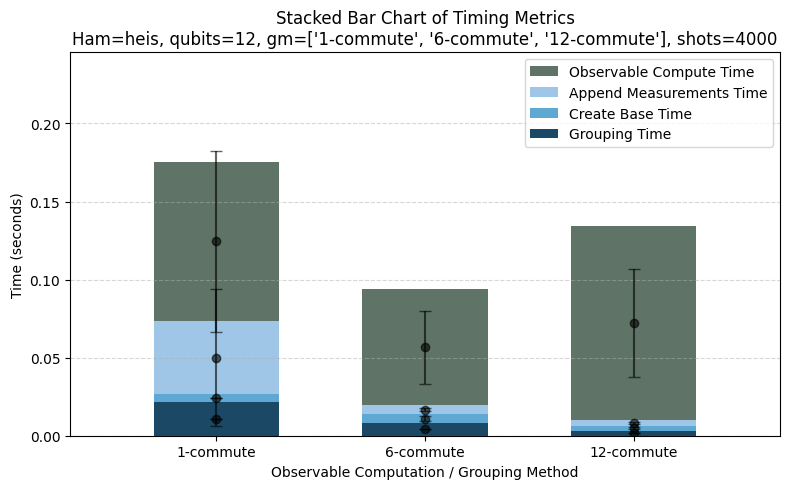

In [ ]:
# Arrange the Pauli terms into commuting groups based on group_method, for use in cells below

from hamlib._common.metric_plots import get_errors
from hamlib._common.new_functions import compute_timing_stats
from hamlib._common.metric_plots import plot_timing_analysis_bar_chart

ks = [1, int(1/2 * num_qubits), num_qubits]
group_method_labels = [f'{num_k}-commute' for num_k in ks]


timing_datasets = []
timing_dataset_labels = []
print("done")

prepare_random_initial_state

initial_states = []
initial_circuits = []
for it in range(iterations):
    init_state, init_qc = prepare_random_initial_state(num_qubits)
    initial_states.append(init_state)
    initial_circuits.append(init_qc)
    

for num_k, group_method_label in zip(ks, group_method_labels):
    print(f'----{num_k} group -----')

    pauli_term_groups, pauli_str_list = hamlib_simulation_benchmark.find_pauli_groups(num_qubits, sparse_pauli_terms, group_method, num_k)
    
    print("")
    print(f"... Number of terms in Hamiltonian: {len(sparse_pauli_terms)}")
    print(f"... Number of groups created: {len(pauli_term_groups)}")
    print("")
    
    print(f"... Pauli Term Groups:")
    
    print("\n======================================================================================")
    print(f"Perform Observable Computation for: {hamiltonian_name} {hamiltonian_params}")
    print(f"... executing on num_qubits = {num_qubits}, shots = {num_shots}")
    print(f"    grouping method = {group_method}, use_diag_method = {use_diag_method}, num_k = {num_k}")
    pauli_term_groups, _ = hamlib_simulation_benchmark.find_pauli_groups(num_qubits, sparse_pauli_terms, group_method, num_k)
    print(f"    number of terms in Hamiltonian = {len(sparse_pauli_terms)}, number of groups created = {len(pauli_term_groups)}")
    
    init_values, exact_energies, computed_energies, metrics_array = do_random_state_loop(num_qubits, sparse_pauli_terms, group_method, num_shots, K, t,
                                                                                     num_k, use_diag_method, iterations, initial_states, initial_circuits, distribute_shots,
                                                                                     backend_id, wsd_method)

    # Generate the value anlysis plots
    std_error, mean = get_errors(
                hamiltonian_name,
                backend_id,
                num_qubits,
                group_method_label,
                num_shots,
                exact_energies,
                computed_energies
            )
    print('error:', std_error)
    print('mean:', mean)


    # Compute statistics for the collected metrics
    stats_result = compute_timing_stats(metrics_array)
    #print(stats_result)
    
    timing_datasets.append(stats_result)
    timing_dataset_labels.append( { "name": "Dataset", "label": f"{group_method_label}" })
    
#categories = ["grouping_time", "create_base_time", "append_measurements_time", "execute_circuits_time", "observable_compute_time"]
categories = ["grouping_time", "create_base_time", "append_measurements_time", "observable_compute_time"]

# Version 1: Markers in the middle of the bars
plot_timing_analysis_bar_chart(
        hamiltonian_name,
        backend_id,
        num_qubits,
        group_method_labels,
        num_shots,
        timing_datasets,
        timing_dataset_labels,
        categories,
        error_bar_position = "middle"
    )


In [12]:

# Note: we will loop over multiples here later
hamiltonian_name, hamiltonian_params, _ = hamiltonians[2]     # just do a single Hamiltonian in this notebook


print(f"\n*******************************************************************************************")

print(f"\nAnalyze Observable Computation Methods for {hamiltonian_name} {hamiltonian_params}\n")

# load the HamLib file for the given hamiltonian name
hamlib_utils.load_hamlib_file(filename=hamiltonian_name)

# return a sparse Pauli list of terms queried from the open HamLib file
sparse_pauli_terms, dataset_name = hamlib_utils.get_hamlib_sparsepaulilist(num_qubits=num_qubits, params=hamiltonian_params)

if not sparse_pauli_terms:
    print(f"\n******** Cannot proceed since no dataset was found for {num_qubits} qubits.\n", flush=True)
    sys.exit()
    
print("")
print(f"... dataset_name = {dataset_name}")
print(f"... number of terms in Hamiltonian = {len(sparse_pauli_terms)}")
#print(f"... sparse_pauli_terms = \n{sparse_pauli_terms}")
print("")



*******************************************************************************************

Analyze Observable Computation Methods for condensedmatter/fermihubbard/FH_D-1 {'1D-grid': 'pbc', 'enc': 'bk', 'U': 12}


... dataset_name = fh-graph-1D-grid-pbc-qubitnodes_Lx-6_U-12_enc-bk
... number of terms in Hamiltonian = 43



done
----1 group -----

... Number of terms in Hamiltonian: 43
... Number of groups created: 9

... Pauli Term Groups:

Perform Observable Computation for: condensedmatter/fermihubbard/FH_D-1 {'1D-grid': 'pbc', 'enc': 'bk', 'U': 12}
... executing on num_qubits = 12, shots = 4000
    grouping method = N, use_diag_method = True, num_k = 1
    number of terms in Hamiltonian = 43, number of groups created = 9

..
⚠️ Warning: Significant negative bias detected in the error distribution!
error: 0.18841531852977678
mean: -0.30746891011905664
----6 group -----

... Number of terms in Hamiltonian: 43
... Number of groups created: 4

... Pauli Term Groups:

Perform Observable Computation for: condensedmatter/fermihubbard/FH_D-1 {'1D-grid': 'pbc', 'enc': 'bk', 'U': 12}
... executing on num_qubits = 12, shots = 4000
    grouping method = N, use_diag_method = True, num_k = 6
    number of terms in Hamiltonian = 43, number of groups created = 4

..
⚠️ Warning: Significant negative bias detected in t

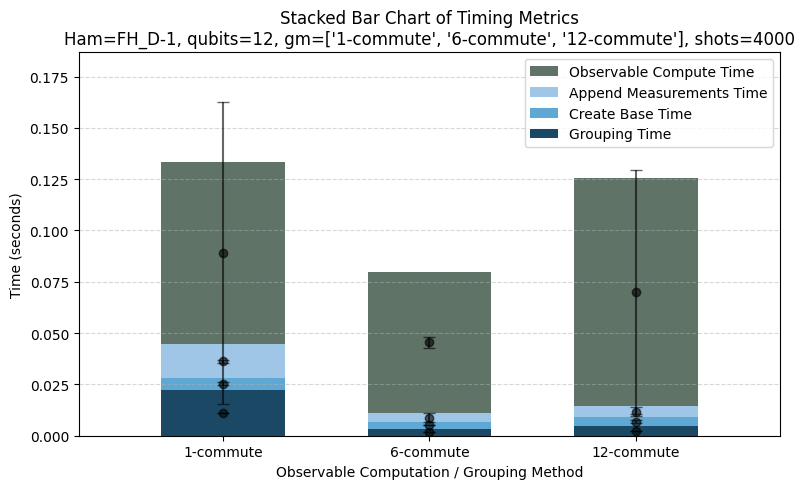

In [ ]:
# Arrange the Pauli terms into commuting groups based on group_method, for use in cells below

from hamlib._common.metric_plots import get_errors
from hamlib._common.new_functions import compute_timing_stats
from hamlib._common.metric_plots import plot_timing_analysis_bar_chart

ks = [1, int(1/2 * num_qubits), num_qubits]
group_method_labels = [f'{num_k}-commute' for num_k in ks]


timing_datasets = []
timing_dataset_labels = []
print("done")

prepare_random_initial_state

initial_states = []
initial_circuits = []
for it in range(iterations):
    init_state, init_qc = prepare_random_initial_state(num_qubits)
    initial_states.append(init_state)
    initial_circuits.append(init_qc)
    

for num_k, group_method_label in zip(ks, group_method_labels):
    print(f'----{num_k} group -----')

    pauli_term_groups, pauli_str_list = hamlib_simulation_benchmark.find_pauli_groups(num_qubits, sparse_pauli_terms, group_method, num_k)
    
    print("")
    print(f"... Number of terms in Hamiltonian: {len(sparse_pauli_terms)}")
    print(f"... Number of groups created: {len(pauli_term_groups)}")
    print("")
    
    print(f"... Pauli Term Groups:")
    
    print("\n======================================================================================")
    print(f"Perform Observable Computation for: {hamiltonian_name} {hamiltonian_params}")
    print(f"... executing on num_qubits = {num_qubits}, shots = {num_shots}")
    print(f"    grouping method = {group_method}, use_diag_method = {use_diag_method}, num_k = {num_k}")
    pauli_term_groups, _ = hamlib_simulation_benchmark.find_pauli_groups(num_qubits, sparse_pauli_terms, group_method, num_k)
    print(f"    number of terms in Hamiltonian = {len(sparse_pauli_terms)}, number of groups created = {len(pauli_term_groups)}")
    
    init_values, exact_energies, computed_energies, metrics_array = do_random_state_loop(num_qubits, sparse_pauli_terms, group_method, num_shots, K, t,
                                                                                         num_k, use_diag_method, iterations, initial_states, initial_circuits, distribute_shots,
                                                                                         backend_id, wsd_method)

    # Generate the value anlysis plots
    std_error, mean = get_errors(
                hamiltonian_name,
                backend_id,
                num_qubits,
                group_method_label,
                num_shots,
                exact_energies,
                computed_energies
            )
    print('error:', std_error)
    print('mean:', mean)


    # Compute statistics for the collected metrics
    stats_result = compute_timing_stats(metrics_array)
    #print(stats_result)
    
    timing_datasets.append(stats_result)
    timing_dataset_labels.append( { "name": "Dataset", "label": f"{group_method_label}" })
    
#categories = ["grouping_time", "create_base_time", "append_measurements_time", "execute_circuits_time", "observable_compute_time"]
categories = ["grouping_time", "create_base_time", "append_measurements_time", "observable_compute_time"]

# Version 1: Markers in the middle of the bars
plot_timing_analysis_bar_chart(
        hamiltonian_name,
        backend_id,
        num_qubits,
        group_method_labels,
        num_shots,
        timing_datasets,
        timing_dataset_labels,
        categories,
        error_bar_position = "middle"
    )


In [14]:

# Note: we will loop over multiples here later
hamiltonian_name, hamiltonian_params, _ = hamiltonians[3]     # just do a single Hamiltonian in this notebook


print(f"\n*******************************************************************************************")

print(f"\nAnalyze Observable Computation Methods for {hamiltonian_name} {hamiltonian_params}\n")

# load the HamLib file for the given hamiltonian name
hamlib_utils.load_hamlib_file(filename=hamiltonian_name)

# return a sparse Pauli list of terms queried from the open HamLib file
sparse_pauli_terms, dataset_name = hamlib_utils.get_hamlib_sparsepaulilist(num_qubits=num_qubits, params=hamiltonian_params)

if not sparse_pauli_terms:
    print(f"\n******** Cannot proceed since no dataset was found for {num_qubits} qubits.\n", flush=True)
    sys.exit()
    
print("")
print(f"... dataset_name = {dataset_name}")
print(f"... number of terms in Hamiltonian = {len(sparse_pauli_terms)}")
#print(f"... sparse_pauli_terms = \n{sparse_pauli_terms}")
print("")



*******************************************************************************************

Analyze Observable Computation Methods for condensedmatter/bosehubbard/BH_D-1_d-4 {'1D-grid': 'nonpbc', 'enc': 'gray', 'U': 10}


... dataset_name = bh_graph-1D-grid-nonpbc-qubitnodes_Lx-6_U-10_enc-gray_d-4
... number of terms in Hamiltonian = 179



done
----1 group -----

... Number of terms in Hamiltonian: 179
... Number of groups created: 12

... Pauli Term Groups:

Perform Observable Computation for: condensedmatter/bosehubbard/BH_D-1_d-4 {'1D-grid': 'nonpbc', 'enc': 'gray', 'U': 10}
... executing on num_qubits = 12, shots = 4000
    grouping method = N, use_diag_method = True, num_k = 1
    number of terms in Hamiltonian = 179, number of groups created = 12

..
⚠️ Warning: Significant negative bias detected in the error distribution!
error: 1.3398784158817456
mean: -1.797784716430801
----6 group -----

... Number of terms in Hamiltonian: 179
... Number of groups created: 18

... Pauli Term Groups:

Perform Observable Computation for: condensedmatter/bosehubbard/BH_D-1_d-4 {'1D-grid': 'nonpbc', 'enc': 'gray', 'U': 10}
... executing on num_qubits = 12, shots = 4000
    grouping method = N, use_diag_method = True, num_k = 6
    number of terms in Hamiltonian = 179, number of groups created = 18

..
⚠️ Warning: Significant negati

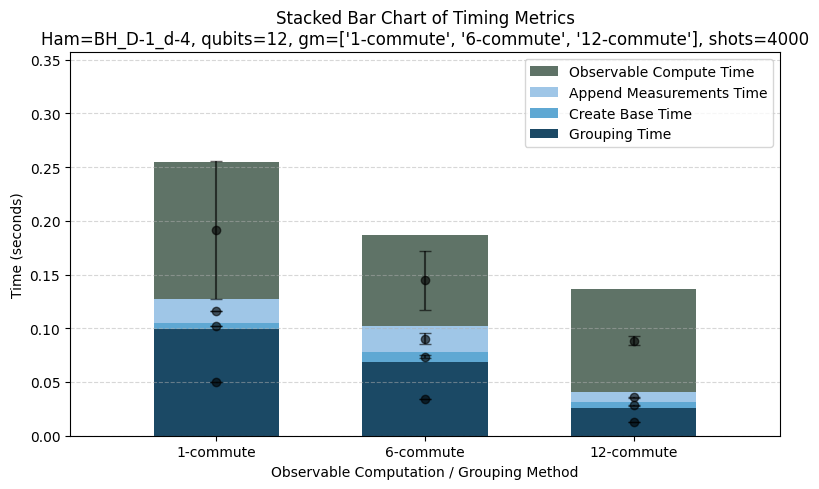

In [ ]:
# Arrange the Pauli terms into commuting groups based on group_method, for use in cells below

from hamlib._common.metric_plots import get_errors
from hamlib._common.new_functions import compute_timing_stats
from hamlib._common.metric_plots import plot_timing_analysis_bar_chart

ks = [1, int(1/2 * num_qubits), num_qubits]
group_method_labels = [f'{num_k}-commute' for num_k in ks]


timing_datasets = []
timing_dataset_labels = []
print("done")

prepare_random_initial_state

initial_states = []
initial_circuits = []
for it in range(iterations):
    init_state, init_qc = prepare_random_initial_state(num_qubits)
    initial_states.append(init_state)
    initial_circuits.append(init_qc)
    

for num_k, group_method_label in zip(ks, group_method_labels):
    print(f'----{num_k} group -----')

    pauli_term_groups, pauli_str_list = hamlib_simulation_benchmark.find_pauli_groups(num_qubits, sparse_pauli_terms, group_method, num_k)
    
    print("")
    print(f"... Number of terms in Hamiltonian: {len(sparse_pauli_terms)}")
    print(f"... Number of groups created: {len(pauli_term_groups)}")
    print("")
    
    print(f"... Pauli Term Groups:")
    
    print("\n======================================================================================")
    print(f"Perform Observable Computation for: {hamiltonian_name} {hamiltonian_params}")
    print(f"... executing on num_qubits = {num_qubits}, shots = {num_shots}")
    print(f"    grouping method = {group_method}, use_diag_method = {use_diag_method}, num_k = {num_k}")
    pauli_term_groups, _ = hamlib_simulation_benchmark.find_pauli_groups(num_qubits, sparse_pauli_terms, group_method, num_k)
    print(f"    number of terms in Hamiltonian = {len(sparse_pauli_terms)}, number of groups created = {len(pauli_term_groups)}")
    
    init_values, exact_energies, computed_energies, metrics_array = do_random_state_loop(num_qubits, sparse_pauli_terms, group_method, num_shots, K, t,
                                                                                         num_k, use_diag_method, iterations, initial_states, initial_circuits, distribute_shots,
                                                                                         backend_id, wsd_method)

    # Generate the value anlysis plots
    std_error, mean = get_errors(
                hamiltonian_name,
                backend_id,
                num_qubits,
                group_method_label,
                num_shots,
                exact_energies,
                computed_energies
            )
    print('error:', std_error)
    print('mean:', mean)


    # Compute statistics for the collected metrics
    stats_result = compute_timing_stats(metrics_array)
    #print(stats_result)
    
    timing_datasets.append(stats_result)
    timing_dataset_labels.append( { "name": "Dataset", "label": f"{group_method_label}" })
    
#categories = ["grouping_time", "create_base_time", "append_measurements_time", "execute_circuits_time", "observable_compute_time"]
categories = ["grouping_time", "create_base_time", "append_measurements_time", "observable_compute_time"]

# Version 1: Markers in the middle of the bars
plot_timing_analysis_bar_chart(
        hamiltonian_name,
        backend_id,
        num_qubits,
        group_method_labels,
        num_shots,
        timing_datasets,
        timing_dataset_labels,
        categories,
        error_bar_position = "middle"
    )


In [16]:

# Note: we will loop over multiples here later
hamiltonian_name, hamiltonian_params, _ = hamiltonians[4]     # just do a single Hamiltonian in this notebook


print(f"\n*******************************************************************************************")

print(f"\nAnalyze Observable Computation Methods for {hamiltonian_name} {hamiltonian_params}\n")

# load the HamLib file for the given hamiltonian name
hamlib_utils.load_hamlib_file(filename=hamiltonian_name)

# return a sparse Pauli list of terms queried from the open HamLib file
sparse_pauli_terms, dataset_name = hamlib_utils.get_hamlib_sparsepaulilist(num_qubits=num_qubits, params=hamiltonian_params)

if not sparse_pauli_terms:
    print(f"\n******** Cannot proceed since no dataset was found for {num_qubits} qubits.\n", flush=True)
    sys.exit()
    
print("")
print(f"... dataset_name = {dataset_name}")
print(f"... number of terms in Hamiltonian = {len(sparse_pauli_terms)}")
#print(f"... sparse_pauli_terms = \n{sparse_pauli_terms}")
print("")



*******************************************************************************************

Analyze Observable Computation Methods for chemistry/electronic/standard/H2 {'ham_BK': ''}


... dataset_name = ham_BK-12
... number of terms in Hamiltonian = 327



done
----1 group -----

... Number of terms in Hamiltonian: 327
... Number of groups created: 58

... Pauli Term Groups:

Perform Observable Computation for: chemistry/electronic/standard/H2 {'ham_BK': ''}
... executing on num_qubits = 12, shots = 4000
    grouping method = N, use_diag_method = True, num_k = 1
    number of terms in Hamiltonian = 327, number of groups created = 58

..
⚠️ Warning: Significant negative bias detected in the error distribution!
error: 0.5735427824867823
mean: -0.3296893501155762
----6 group -----

... Number of terms in Hamiltonian: 327
... Number of groups created: 26

... Pauli Term Groups:

Perform Observable Computation for: chemistry/electronic/standard/H2 {'ham_BK': ''}
... executing on num_qubits = 12, shots = 4000
    grouping method = N, use_diag_method = True, num_k = 6
    number of terms in Hamiltonian = 327, number of groups created = 26

..
⚠️ Warning: Significant negative bias detected in the error distribution!
error: 0.030761097030770124
m

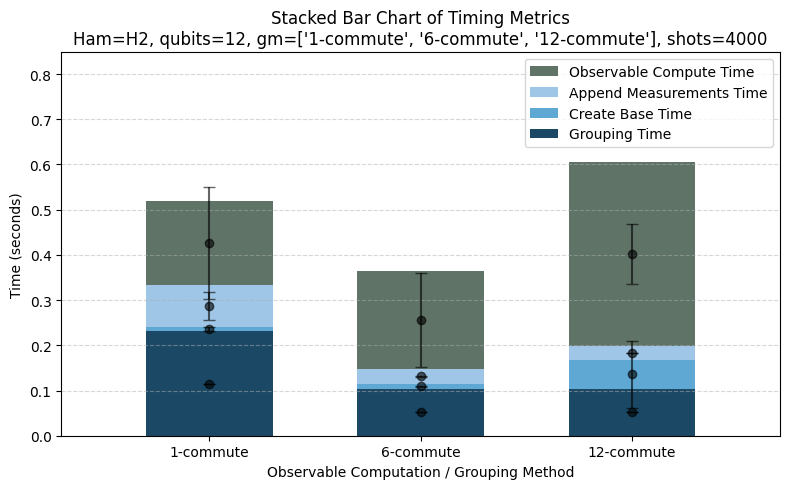

In [17]:
timing_datasets = []
timing_dataset_labels = []
print("done")

prepare_random_initial_state

initial_states = []
initial_circuits = []
for it in range(iterations):
    init_state, init_qc = prepare_random_initial_state(num_qubits)
    initial_states.append(init_state)
    initial_circuits.append(init_qc)
    

for num_k, group_method_label in zip(ks, group_method_labels):
    print(f'----{num_k} group -----')

    pauli_term_groups, pauli_str_list = hamlib_simulation_benchmark.find_pauli_groups(num_qubits, sparse_pauli_terms, group_method, num_k)
    
    print("")
    print(f"... Number of terms in Hamiltonian: {len(sparse_pauli_terms)}")
    print(f"... Number of groups created: {len(pauli_term_groups)}")
    print("")
    
    print(f"... Pauli Term Groups:")
    
    print("\n======================================================================================")
    print(f"Perform Observable Computation for: {hamiltonian_name} {hamiltonian_params}")
    print(f"... executing on num_qubits = {num_qubits}, shots = {num_shots}")
    print(f"    grouping method = {group_method}, use_diag_method = {use_diag_method}, num_k = {num_k}")
    pauli_term_groups, _ = hamlib_simulation_benchmark.find_pauli_groups(num_qubits, sparse_pauli_terms, group_method, num_k)
    print(f"    number of terms in Hamiltonian = {len(sparse_pauli_terms)}, number of groups created = {len(pauli_term_groups)}")
    
    init_values, exact_energies, computed_energies, metrics_array = do_random_state_loop(num_qubits, sparse_pauli_terms, group_method, num_shots, K, t,
                                                                                         num_k, use_diag_method, iterations, initial_states, initial_circuits, distribute_shots,
                                                                                         backend_id, wsd_method)

    # Generate the value anlysis plots
    std_error, mean = get_errors(
                hamiltonian_name,
                backend_id,
                num_qubits,
                group_method_label,
                num_shots,
                exact_energies,
                computed_energies
            )
    print('error:', std_error)
    print('mean:', mean)


    # Compute statistics for the collected metrics
    stats_result = compute_timing_stats(metrics_array)
    #print(stats_result)
    
    timing_datasets.append(stats_result)
    timing_dataset_labels.append( { "name": "Dataset", "label": f"{group_method_label}" })
    
#categories = ["grouping_time", "create_base_time", "append_measurements_time", "execute_circuits_time", "observable_compute_time"]
categories = ["grouping_time", "create_base_time", "append_measurements_time", "observable_compute_time"]

# Version 1: Markers in the middle of the bars
plot_timing_analysis_bar_chart(
        hamiltonian_name,
        backend_id,
        num_qubits,
        group_method_labels,
        num_shots,
        timing_datasets,
        timing_dataset_labels,
        categories,
        error_bar_position = "middle"
    )


In [18]:

# Note: we will loop over multiples here later
hamiltonian_name, hamiltonian_params, _ = hamiltonians[5]     # just do a single Hamiltonian in this notebook


print(f"\n*******************************************************************************************")

print(f"\nAnalyze Observable Computation Methods for {hamiltonian_name} {hamiltonian_params}\n")

# load the HamLib file for the given hamiltonian name
hamlib_utils.load_hamlib_file(filename=hamiltonian_name)

# return a sparse Pauli list of terms queried from the open HamLib file
sparse_pauli_terms, dataset_name = hamlib_utils.get_hamlib_sparsepaulilist(num_qubits=num_qubits, params=hamiltonian_params)

if not sparse_pauli_terms:
    print(f"\n******** Cannot proceed since no dataset was found for {num_qubits} qubits.\n", flush=True)
    sys.exit()
    
print("")
print(f"... dataset_name = {dataset_name}")
print(f"... number of terms in Hamiltonian = {len(sparse_pauli_terms)}")
#print(f"... sparse_pauli_terms = \n{sparse_pauli_terms}")
print("")



*******************************************************************************************

Analyze Observable Computation Methods for chemistry/electronic/standard/B2 {'ham_BK': ''}


... dataset_name = ham_BK-12
... number of terms in Hamiltonian = 287



done
----1 group -----

... Number of terms in Hamiltonian: 287
... Number of groups created: 87

... Pauli Term Groups:

Perform Observable Computation for: chemistry/electronic/standard/B2 {'ham_BK': ''}
... executing on num_qubits = 12, shots = 4000
    grouping method = N, use_diag_method = True, num_k = 1
    number of terms in Hamiltonian = 287, number of groups created = 87

..
⚠️ Warning: Significant negative bias detected in the error distribution!
error: 0.05068400358593905
mean: -0.013388914847798361
----6 group -----

... Number of terms in Hamiltonian: 287
... Number of groups created: 36

... Pauli Term Groups:

Perform Observable Computation for: chemistry/electronic/standard/B2 {'ham_BK': ''}
... executing on num_qubits = 12, shots = 4000
    grouping method = N, use_diag_method = True, num_k = 6
    number of terms in Hamiltonian = 287, number of groups created = 36

..
⚠️ Warning: Significant positive bias detected in the error distribution!
error: 0.01081813634724326

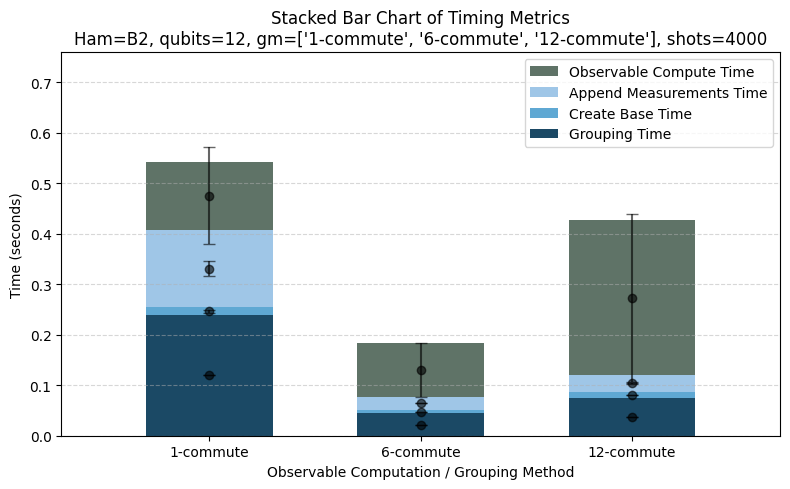

In [19]:
timing_datasets = []
timing_dataset_labels = []
print("done")

prepare_random_initial_state

initial_states = []
initial_circuits = []
for it in range(iterations):
    init_state, init_qc = prepare_random_initial_state(num_qubits)
    initial_states.append(init_state)
    initial_circuits.append(init_qc)
    

for num_k, group_method_label in zip(ks, group_method_labels):
    print(f'----{num_k} group -----')

    pauli_term_groups, pauli_str_list = hamlib_simulation_benchmark.find_pauli_groups(num_qubits, sparse_pauli_terms, group_method, num_k)
    
    print("")
    print(f"... Number of terms in Hamiltonian: {len(sparse_pauli_terms)}")
    print(f"... Number of groups created: {len(pauli_term_groups)}")
    print("")
    
    print(f"... Pauli Term Groups:")
    
    print("\n======================================================================================")
    print(f"Perform Observable Computation for: {hamiltonian_name} {hamiltonian_params}")
    print(f"... executing on num_qubits = {num_qubits}, shots = {num_shots}")
    print(f"    grouping method = {group_method}, use_diag_method = {use_diag_method}, num_k = {num_k}")
    pauli_term_groups, _ = hamlib_simulation_benchmark.find_pauli_groups(num_qubits, sparse_pauli_terms, group_method, num_k)
    print(f"    number of terms in Hamiltonian = {len(sparse_pauli_terms)}, number of groups created = {len(pauli_term_groups)}")
    
    init_values, exact_energies, computed_energies, metrics_array = do_random_state_loop(num_qubits, sparse_pauli_terms, group_method, num_shots, K, t,
                                                                                         num_k, use_diag_method, iterations, initial_states, initial_circuits, distribute_shots,
                                                                                         backend_id, wsd_method)

    # Generate the value anlysis plots
    std_error, mean = get_errors(
                hamiltonian_name,
                backend_id,
                num_qubits,
                group_method_label,
                num_shots,
                exact_energies,
                computed_energies
            )
    print('error:', std_error)
    print('mean:', mean)


    # Compute statistics for the collected metrics
    stats_result = compute_timing_stats(metrics_array)
    #print(stats_result)
    
    timing_datasets.append(stats_result)
    timing_dataset_labels.append( { "name": "Dataset", "label": f"{group_method_label}" })
    
#categories = ["grouping_time", "create_base_time", "append_measurements_time", "execute_circuits_time", "observable_compute_time"]
categories = ["grouping_time", "create_base_time", "append_measurements_time", "observable_compute_time"]

# Version 1: Markers in the middle of the bars
plot_timing_analysis_bar_chart(
        hamiltonian_name,
        backend_id,
        num_qubits,
        group_method_labels,
        num_shots,
        timing_datasets,
        timing_dataset_labels,
        categories,
        error_bar_position = "middle"
    )


In [20]:

# Note: we will loop over multiples here later
hamiltonian_name, hamiltonian_params, _ = hamiltonians[6]     # just do a single Hamiltonian in this notebook


print(f"\n*******************************************************************************************")

print(f"\nAnalyze Observable Computation Methods for {hamiltonian_name} {hamiltonian_params}\n")

# load the HamLib file for the given hamiltonian name
hamlib_utils.load_hamlib_file(filename=hamiltonian_name)

# return a sparse Pauli list of terms queried from the open HamLib file
sparse_pauli_terms, dataset_name = hamlib_utils.get_hamlib_sparsepaulilist(num_qubits=num_qubits, params=hamiltonian_params)

if not sparse_pauli_terms:
    print(f"\n******** Cannot proceed since no dataset was found for {num_qubits} qubits.\n", flush=True)
    sys.exit()
    
print("")
print(f"... dataset_name = {dataset_name}")
print(f"... number of terms in Hamiltonian = {len(sparse_pauli_terms)}")
#print(f"... sparse_pauli_terms = \n{sparse_pauli_terms}")
print("")



*******************************************************************************************

Analyze Observable Computation Methods for chemistry/electronic/standard/NH {'ham_BK': ''}


... dataset_name = ham_BK-12
... number of terms in Hamiltonian = 631



done
----1 group -----

... Number of terms in Hamiltonian: 631
... Number of groups created: 161

... Pauli Term Groups:

Perform Observable Computation for: chemistry/electronic/standard/NH {'ham_BK': ''}
... executing on num_qubits = 12, shots = 4000
    grouping method = N, use_diag_method = True, num_k = 1
    number of terms in Hamiltonian = 631, number of groups created = 161

..
⚠️ Warning: Significant positive bias detected in the error distribution!
error: 0.04527743264521433
mean: 0.188238092404319
----6 group -----

... Number of terms in Hamiltonian: 631
... Number of groups created: 79

... Pauli Term Groups:

Perform Observable Computation for: chemistry/electronic/standard/NH {'ham_BK': ''}
... executing on num_qubits = 12, shots = 4000
    grouping method = N, use_diag_method = True, num_k = 6
    number of terms in Hamiltonian = 631, number of groups created = 79

..
⚠️ Warning: Significant positive bias detected in the error distribution!
error: 0.09230499947894444
m

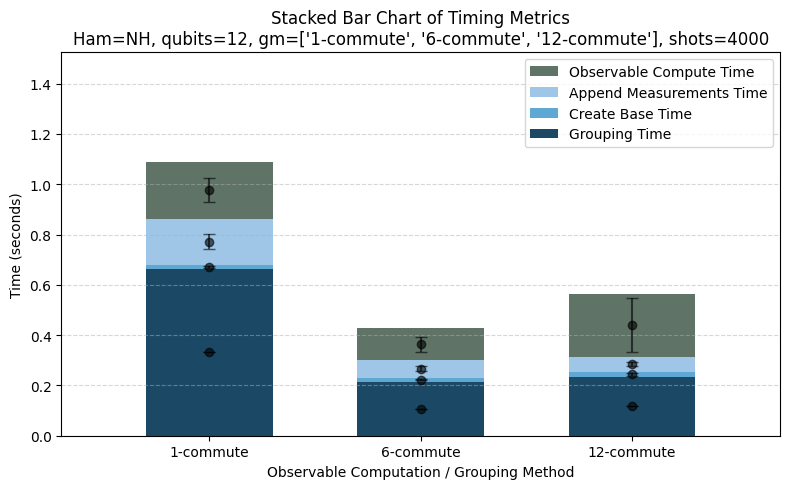

In [21]:
timing_datasets = []
timing_dataset_labels = []
print("done")

prepare_random_initial_state

initial_states = []
initial_circuits = []
for it in range(iterations):
    init_state, init_qc = prepare_random_initial_state(num_qubits)
    initial_states.append(init_state)
    initial_circuits.append(init_qc)
    

for num_k, group_method_label in zip(ks, group_method_labels):
    print(f'----{num_k} group -----')

    pauli_term_groups, pauli_str_list = hamlib_simulation_benchmark.find_pauli_groups(num_qubits, sparse_pauli_terms, group_method, num_k)
    
    print("")
    print(f"... Number of terms in Hamiltonian: {len(sparse_pauli_terms)}")
    print(f"... Number of groups created: {len(pauli_term_groups)}")
    print("")
    
    print(f"... Pauli Term Groups:")
    
    print("\n======================================================================================")
    print(f"Perform Observable Computation for: {hamiltonian_name} {hamiltonian_params}")
    print(f"... executing on num_qubits = {num_qubits}, shots = {num_shots}")
    print(f"    grouping method = {group_method}, use_diag_method = {use_diag_method}, num_k = {num_k}")
    pauli_term_groups, _ = hamlib_simulation_benchmark.find_pauli_groups(num_qubits, sparse_pauli_terms, group_method, num_k)
    print(f"    number of terms in Hamiltonian = {len(sparse_pauli_terms)}, number of groups created = {len(pauli_term_groups)}")
    
    init_values, exact_energies, computed_energies, metrics_array = do_random_state_loop(num_qubits, sparse_pauli_terms, group_method, num_shots, K, t,
                                                                                         num_k, use_diag_method, iterations, initial_states, initial_circuits, distribute_shots,
                                                                                         backend_id, wsd_method)


    # Generate the value anlysis plots
    std_error, mean = get_errors(
                hamiltonian_name,
                backend_id,
                num_qubits,
                group_method_label,
                num_shots,
                exact_energies,
                computed_energies
            )
    print('error:', std_error)
    print('mean:', mean)


    # Compute statistics for the collected metrics
    stats_result = compute_timing_stats(metrics_array)
    #print(stats_result)
    
    timing_datasets.append(stats_result)
    timing_dataset_labels.append( { "name": "Dataset", "label": f"{group_method_label}" })
    
#categories = ["grouping_time", "create_base_time", "append_measurements_time", "execute_circuits_time", "observable_compute_time"]
categories = ["grouping_time", "create_base_time", "append_measurements_time", "observable_compute_time"]

# Version 1: Markers in the middle of the bars
plot_timing_analysis_bar_chart(
        hamiltonian_name,
        backend_id,
        num_qubits,
        group_method_labels,
        num_shots,
        timing_datasets,
        timing_dataset_labels,
        categories,
        error_bar_position = "middle"
    )


In [22]:

# Note: we will loop over multiples here later
hamiltonian_name, hamiltonian_params, _ = hamiltonians[7]     # just do a single Hamiltonian in this notebook


print(f"\n*******************************************************************************************")

print(f"\nAnalyze Observable Computation Methods for {hamiltonian_name} {hamiltonian_params}\n")

# load the HamLib file for the given hamiltonian name
hamlib_utils.load_hamlib_file(filename=hamiltonian_name)

# return a sparse Pauli list of terms queried from the open HamLib file
sparse_pauli_terms, dataset_name = hamlib_utils.get_hamlib_sparsepaulilist(num_qubits=num_qubits, params=hamiltonian_params)

if not sparse_pauli_terms:
    print(f"\n******** Cannot proceed since no dataset was found for {num_qubits} qubits.\n", flush=True)
    sys.exit()
    
print("")
print(f"... dataset_name = {dataset_name}")
print(f"... number of terms in Hamiltonian = {len(sparse_pauli_terms)}")
#print(f"... sparse_pauli_terms = \n{sparse_pauli_terms}")
print("")



*******************************************************************************************

Analyze Observable Computation Methods for chemistry/electronic/standard/CH {'ham_BK': ''}


... dataset_name = ham_BK-12
... number of terms in Hamiltonian = 631



done
----1 group -----

... Number of terms in Hamiltonian: 631
... Number of groups created: 162

... Pauli Term Groups:

Perform Observable Computation for: chemistry/electronic/standard/CH {'ham_BK': ''}
... executing on num_qubits = 12, shots = 4000
    grouping method = N, use_diag_method = True, num_k = 1
    number of terms in Hamiltonian = 631, number of groups created = 162

..
✅ No significant bias detected.
error: 0.03296892487485792
mean: -0.006802318040563193
----6 group -----

... Number of terms in Hamiltonian: 631
... Number of groups created: 78

... Pauli Term Groups:

Perform Observable Computation for: chemistry/electronic/standard/CH {'ham_BK': ''}
... executing on num_qubits = 12, shots = 4000
    grouping method = N, use_diag_method = True, num_k = 6
    number of terms in Hamiltonian = 631, number of groups created = 78

..
⚠️ Warning: Significant negative bias detected in the error distribution!
error: 0.3389818777873863
mean: -0.12102907871194546
----12 group 

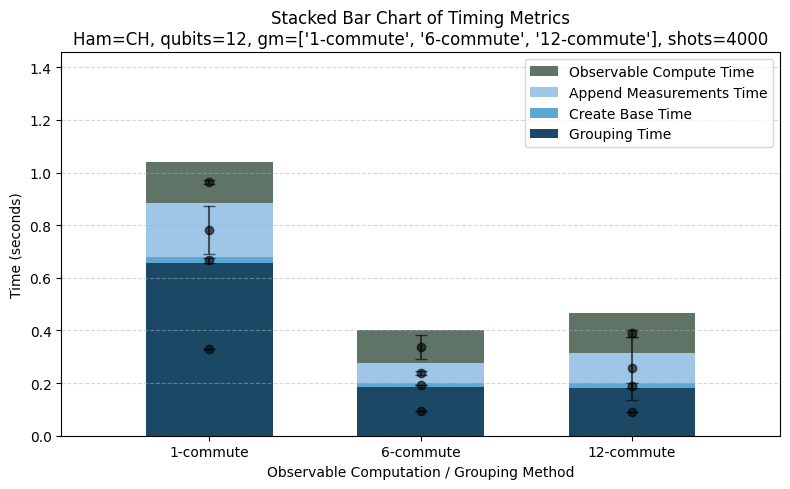

In [23]:
timing_datasets = []
timing_dataset_labels = []
print("done")

prepare_random_initial_state

initial_states = []
initial_circuits = []
for it in range(iterations):
    init_state, init_qc = prepare_random_initial_state(num_qubits)
    initial_states.append(init_state)
    initial_circuits.append(init_qc)
    

for num_k, group_method_label in zip(ks, group_method_labels):
    print(f'----{num_k} group -----')

    pauli_term_groups, pauli_str_list = hamlib_simulation_benchmark.find_pauli_groups(num_qubits, sparse_pauli_terms, group_method, num_k)
    
    print("")
    print(f"... Number of terms in Hamiltonian: {len(sparse_pauli_terms)}")
    print(f"... Number of groups created: {len(pauli_term_groups)}")
    print("")
    
    print(f"... Pauli Term Groups:")
    
    print("\n======================================================================================")
    print(f"Perform Observable Computation for: {hamiltonian_name} {hamiltonian_params}")
    print(f"... executing on num_qubits = {num_qubits}, shots = {num_shots}")
    print(f"    grouping method = {group_method}, use_diag_method = {use_diag_method}, num_k = {num_k}")
    pauli_term_groups, _ = hamlib_simulation_benchmark.find_pauli_groups(num_qubits, sparse_pauli_terms, group_method, num_k)
    print(f"    number of terms in Hamiltonian = {len(sparse_pauli_terms)}, number of groups created = {len(pauli_term_groups)}")
    
    init_values, exact_energies, computed_energies, metrics_array = do_random_state_loop(num_qubits, sparse_pauli_terms, group_method, num_shots, K, t,
                                                                                         num_k, use_diag_method, iterations, initial_states, initial_circuits, distribute_shots,
                                                                                         backend_id, wsd_method)

    # Generate the value anlysis plots
    std_error, mean = get_errors(
                hamiltonian_name,
                backend_id,
                num_qubits,
                group_method_label,
                num_shots,
                exact_energies,
                computed_energies
            )
    print('error:', std_error)
    print('mean:', mean)


    # Compute statistics for the collected metrics
    stats_result = compute_timing_stats(metrics_array)
    #print(stats_result)
    
    timing_datasets.append(stats_result)
    timing_dataset_labels.append( { "name": "Dataset", "label": f"{group_method_label}" })
    
#categories = ["grouping_time", "create_base_time", "append_measurements_time", "execute_circuits_time", "observable_compute_time"]
categories = ["grouping_time", "create_base_time", "append_measurements_time", "observable_compute_time"]

# Version 1: Markers in the middle of the bars
plot_timing_analysis_bar_chart(
        hamiltonian_name,
        backend_id,
        num_qubits,
        group_method_labels,
        num_shots,
        timing_datasets,
        timing_dataset_labels,
        categories,
        error_bar_position = "middle"
    )


In [ ]:
# from hamlib._common.metric_plots import plot_value_analysis_data

# from hamlib._common.new_functions import compute_timing_stats
# from hamlib._common.metric_plots import plot_timing_analysis_bar_chart

# timing_datasets = []
# timing_dataset_labels = []
    
# for group_method_label in group_method_list:
#     global use_diag_method, num_k
#     global distribute_shots

#     if group_method_label is not None and ":" in group_method_label:
#         parts = group_method_label.split(":")
#         group_method = parts[0]
#         #last_part = parts[-1]
#         distribute_shots = True
#     else:
#         group_method = group_method_label
#         distribute_shots = False
  
#     if group_method == "N":
#         use_diag_method = True
#         num_k = num_qubits
#     else:
#         use_diag_method = False
#         num_k = 1

#     print("\n============================================================\n")
#     print(f"Testing expectation grouping method: {group_method_label}\n") 

#     init_values, exact_energies, computed_energies, metrics_array = do_random_state_loop()
#     print("done")

#     # Generate the value anlysis plots
#     plot_value_analysis_data(
#             hamiltonian_name,
#             backend_id,
#             num_qubits,
#             group_method_label,
#             num_shots,
#             init_values, 
#             exact_energies,
#             computed_energies
#         )

#     # Compute statistics for the collected metrics
#     stats_result = compute_timing_stats(metrics_array)
#     #print(stats_result)
    
#     timing_datasets.append(stats_result)
#     timing_dataset_labels.append( { "name": "Dataset", "label": f"{group_method_label}" })

# #categories = ["grouping_time", "create_base_time", "append_measurements_time", "execute_circuits_time", "observable_compute_time"]
# categories = ["grouping_time", "create_base_time", "append_measurements_time", "observable_compute_time"]

# # Version 1: Markers in the middle of the bars
# plot_timing_analysis_bar_chart(
#         hamiltonian_name,
#         backend_id,
#         num_qubits,
#         group_method_label,
#         num_shots,
#         timing_datasets,
#         timing_dataset_labels,
#         categories,
#         error_bar_position = "middle"
#     )

# # Version 2: Error bars at the top of the bars
# #plot_timing_analysis_bar_chart(datasets, dataset_labels, error_bar_position="top")


In [25]:

# # print(timing_datasets)
# # print(timing_dataset_labels)

# categories = ["grouping_time", "create_base_time", "append_measurements_time", "execute_circuits_time", "observable_compute_time"]
# #categories = ["grouping_time", "create_base_time", "append_measurements_time", "observable_compute_time"]

# # Version 1: Markers in the middle of the bars
# plot_timing_analysis_bar_chart(
#         hamiltonian_name,
#         backend_id,
#         num_qubits,
#         group_method,
#         num_shots,
#         timing_datasets,
#         timing_dataset_labels,
#         categories,
#         error_bar_position = "middle"
#     )

# # Version 2: Error bars at the top of the bars
# #plot_timing_analysis_bar_chart(datasets, dataset_labels, error_bar_position="top")


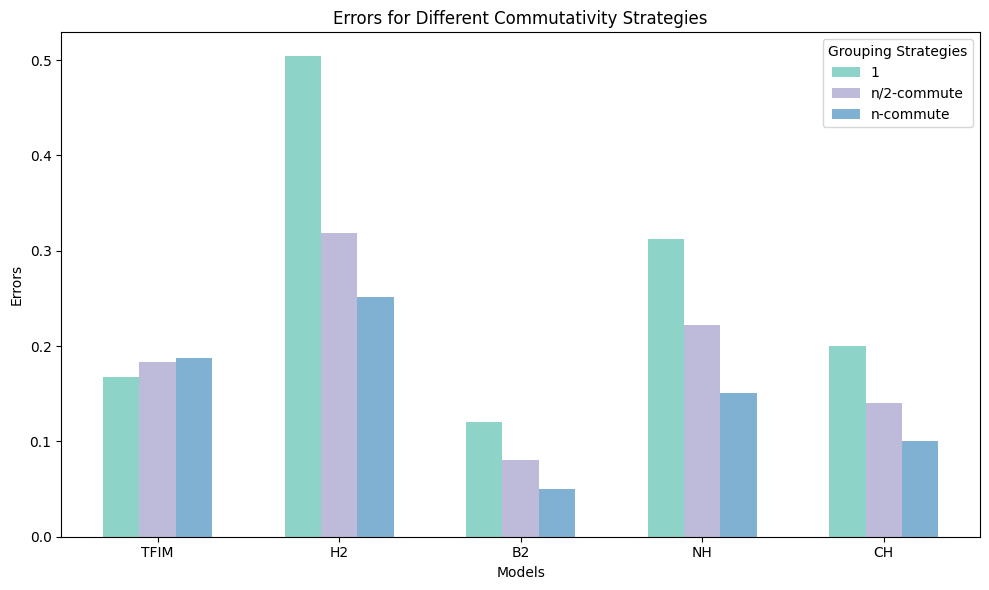

In [26]:
import matplotlib.pyplot as plt
# Data
models = ['TFIM', 'H2', 'B2', 'NH', 'CH']
errors = {
    '1': [0.168, 0.504, 0.12, 0.312, 0.2],
    'n/2-commute': [0.183, 0.319, 0.08, 0.222, 0.14],
    'n-commute': [0.188, 0.252, 0.05, 0.151, 0.1]
}

# Bar chart setup
x = np.arange(len(models))
width = 0.2

fig, ax = plt.subplots(figsize=(10, 6))

# Use the same eye-friendly colors as before
colors = ['#8dd3c7', '#bebada', '#80b1d3']

# Plot bars
for idx, (label, vals) in enumerate(errors.items()):
    ax.bar(x + idx * width, vals, width, label=label, color=colors[idx])

# Formatting
ax.set_xlabel('Models')
ax.set_ylabel('Errors')
ax.set_title('Errors for Different Commutativity Strategies')
ax.set_xticks(x + width)
ax.set_xticklabels(models)
ax.legend(title='Grouping Strategies')

fig.tight_layout()
plt.show()


In [27]:
errors = {
    "TFIM": {
        "1": 0.168,
        "n/2-commute": 0.183,
        "n-commute": 0.188
    },
    "Heis": {
        "1": 0.23700985430363491,
        "n/2-commute": 0.3116526453554655,
        "n-commute": 0.2378343132024073
    },
    "Fermi-Hubbard": {
        "1": 0.6277680602530227,
        "n/2-commute": 0.5560090477568612,
        "n-commute": 0.5143599515312738
    },
    "Bose-Hubbard": {
        "1": 1.9147126497190854,
        "n/2-commute": 2.049815460511045,
        "n-commute": 1.8982632347808976
    },
    "H2": {
        "1": 0.504,
        "n/2-commute": 0.319,
        "n-commute": 0.252
    },
    "B2": {
        "1": 0.120,
        "n/2-commute": 0.080,
        "n-commute": 0.050
    },
    "NH": {
        "1": 0.312,
        "n/2-commute": 0.222,
        "n-commute": 0.151
    },
    "CH": {
        "1": 0.200,
        "n/2-commute": 0.140,
        "n-commute": 0.100
    }
}


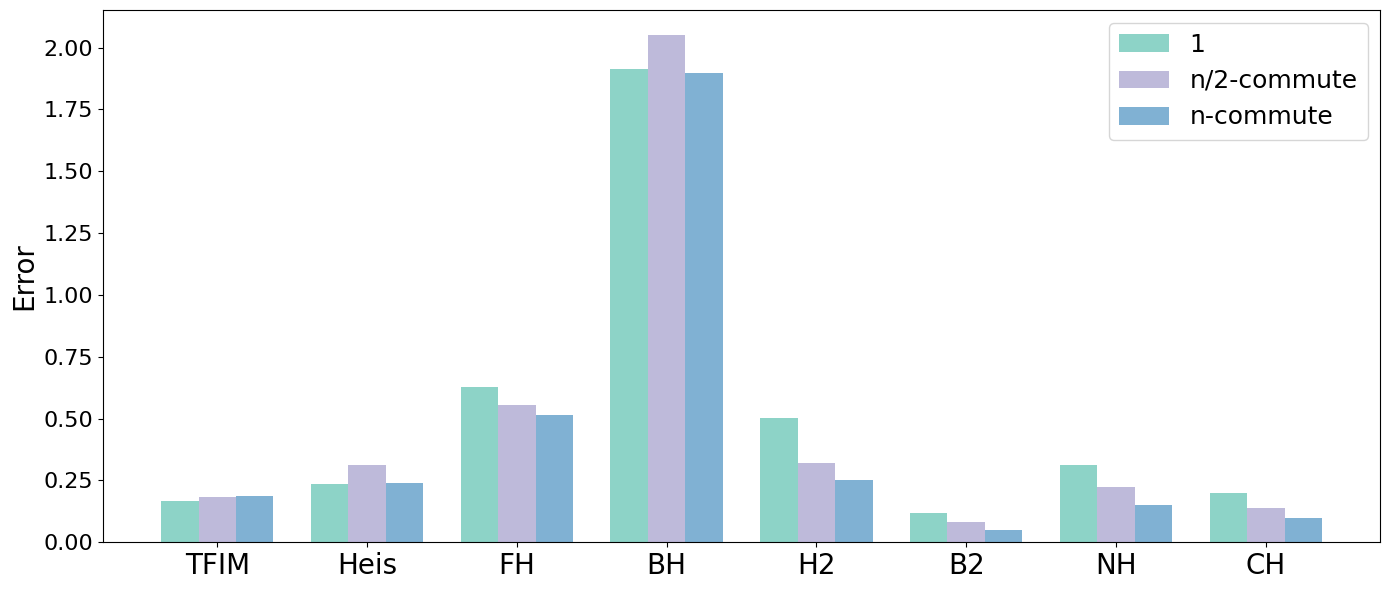

In [28]:
import matplotlib.pyplot as plt
import numpy as np

# Updated data
models = ['TFIM', 'Heis', 'FH', 'BH', 'H2', 'B2', 'NH', 'CH']
errors = {
    '1': [0.168, 0.23700985430363491, 0.6277680602530227, 1.9147126497190854, 0.504, 0.12, 0.312, 0.2],
    'n/2-commute': [0.183, 0.3116526453554655, 0.5560090477568612, 2.049815460511045, 0.319, 0.08, 0.222, 0.14],
    'n-commute': [0.188, 0.2378343132024073, 0.5143599515312738, 1.8982632347808976, 0.252, 0.05, 0.151, 0.1]
}

# Bar chart setup
x = np.arange(len(models))
width = 0.25
colors =  ['#8dd3c7', '#bebada', '#80b1d3']
fig, ax = plt.subplots(figsize=(14, 6))

# Plot bars
for idx, (label, vals) in enumerate(errors.items()):
    ax.bar(x + idx * width - width, vals, width, label=label, color=colors[idx])

# Formatting
ax.set_ylabel('Error', size=20)
ax.set_xticks(x)
ax.set_xticklabels(models, size=20)
ax.legend(fontsize=18)
ax.tick_params(axis='y', labelsize=16)

plt.savefig('exp2-k-ERROR.pdf')
fig.tight_layout()
plt.show()
